In [1]:
%load_ext autoreload
%autoreload 2

from typing import Any

import os
from os.path import join
import shutil
import random
from copy import deepcopy
from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

from settings import *
from validation_model import ValidationModel

In [2]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
samples = np.load(SAMPLES_PATH)
samples = np.c_[samples["labels"], samples["faces"]]

In [4]:
face_train, face_test, label_train, label_test = train_test_split(samples[:, 1], samples[:, 0].astype(np.bool_), test_size=0.06)

print("train size:", label_train.shape)
print("test size:", label_test.shape)

train size: (5040,)
test size: (322,)


## Train model

In [5]:
class FaceDataset(Dataset):
    def __init__(self, images: list, labels: list, device) -> None:
        super().__init__()

        self.images = deepcopy(images)
        self.labels = deepcopy(labels)
        self.device = device

        self.labels = torch.tensor(
            self.labels, dtype=torch.float, device=device
        ).unsqueeze(1)

    def __getitem__(self, index) -> Any:
        np_img = imread(self.images[index])
        tensor_img = (
            torch.tensor(np_img, dtype=torch.float, device=self.device)
            .permute(2, 0, 1)
            .divide(255)
        )

        return tensor_img, self.labels[index]

    def __len__(self):
        return len(self.labels)

In [9]:
# constants
LEARNING_RATE = 0.00001
BATCH_SIZE = 16

total_epochs = 0

train_ds = FaceDataset(face_train, label_train, DEVICE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = FaceDataset(face_test, label_test, DEVICE)
test_dl = DataLoader(test_ds, batch_size=len(label_test))

# model instance
model = ValidationModel().to(DEVICE)

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, LEARNING_RATE, total_iters=200, last_epoch=-1, verbose=False)

train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [10]:
# Training loop
for epoch in range(200):
    model.train()
    avg_loss = 0.0
    avg_acc = 0.0

    for batch_imgs, batch_labels in train_dl:
        optimizer.zero_grad()
        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # eval
        preds = outputs.detach().cpu().numpy() > 0.5
        labels = batch_labels.cpu().numpy()
        avg_acc += (preds == labels).sum()

        avg_loss += loss.item()

    avg_acc /= train_ds.__len__()
    train_acc.append(avg_acc)
    avg_loss /= len(train_dl)
    train_loss.append(avg_loss)

    # test eval
    model.eval()
    with torch.no_grad():
        for batch_imgs, batch_labels in test_dl:
            # loss
            outputs = model(batch_imgs)
            loss = criterion(outputs, batch_labels)
            test_loss.append(loss.item())

            # accuracy
            preds = outputs.detach().cpu().numpy() > 0.5
            labels = batch_labels.cpu().numpy()
            accuracy = (preds == labels).sum() / len(preds)
            test_acc.append(accuracy)

    print(
        f"[epoch {total_epochs+1:03d}] [loss {train_loss[-1]:.4f} | {test_loss[-1]:.4f}] [acc {train_acc[-1]:.4f} | {test_acc[-1]:.4f}]",
        end="\t",
    )
    if (epoch + 1) % 3 == 0:
        print()

    # save progress
    torch.save(model.state_dict(), f"./checkpoints_vm/epoch-{total_epochs + 1}.pth")

    total_epochs += 1

print("Training complete.")

[epoch 001] [loss 0.8005 | 0.6441] [acc 0.5077 | 0.6832]	[epoch 002] [loss 0.7336 | 0.6017] [acc 0.5812 | 0.6832]	[epoch 003] [loss 0.7163 | 0.5792] [acc 0.6028 | 0.6832]	
[epoch 004] [loss 0.6939 | 0.5576] [acc 0.6206 | 0.6832]	[epoch 005] [loss 0.6684 | 0.5369] [acc 0.6361 | 0.6863]	[epoch 006] [loss 0.6443 | 0.5176] [acc 0.6643 | 0.7050]	
[epoch 007] [loss 0.6139 | 0.4958] [acc 0.6754 | 0.7391]	[epoch 008] [loss 0.6134 | 0.4733] [acc 0.6841 | 0.7671]	[epoch 009] [loss 0.5860 | 0.4536] [acc 0.6978 | 0.8043]	
[epoch 010] [loss 0.5637 | 0.4355] [acc 0.7095 | 0.8106]	[epoch 011] [loss 0.5473 | 0.4178] [acc 0.7284 | 0.8292]	[epoch 012] [loss 0.5134 | 0.4010] [acc 0.7605 | 0.8385]	
[epoch 013] [loss 0.5024 | 0.3894] [acc 0.7615 | 0.8416]	[epoch 014] [loss 0.4872 | 0.3766] [acc 0.7720 | 0.8509]	[epoch 015] [loss 0.4744 | 0.3661] [acc 0.7831 | 0.8571]	
[epoch 016] [loss 0.4509 | 0.3580] [acc 0.8032 | 0.8540]	[epoch 017] [loss 0.4526 | 0.3555] [acc 0.7992 | 0.8509]	[epoch 018] [loss 0.4258 |

## Evaluation

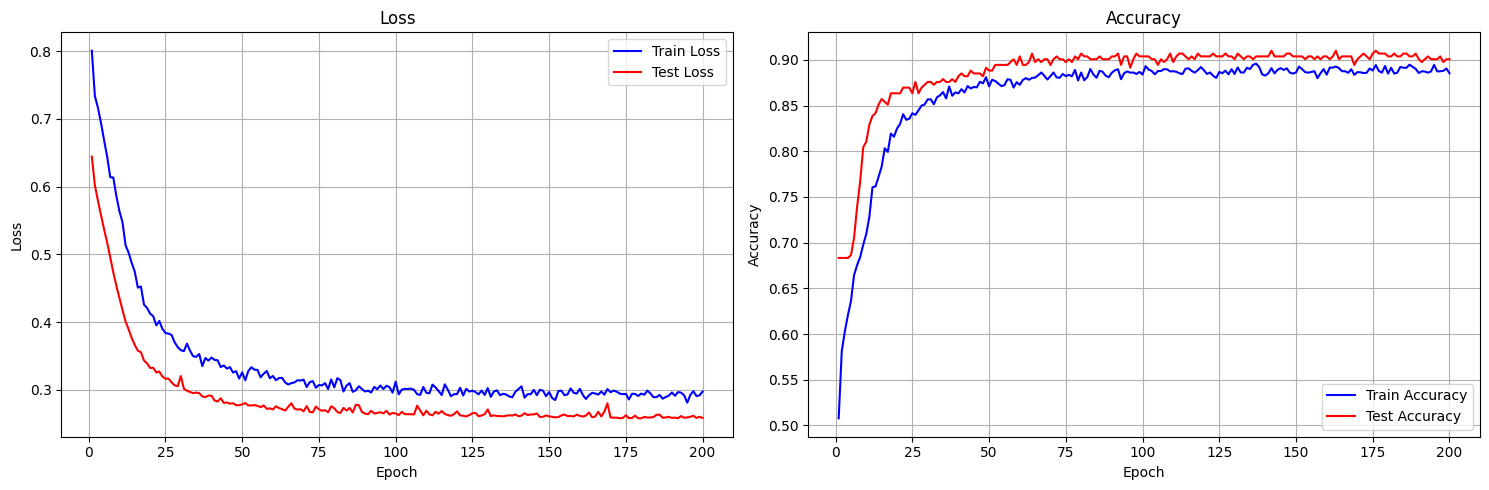

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax[0].plot(range(1, total_epochs + 1), train_loss, c='blue')
ax[0].plot(range(1, total_epochs + 1), test_loss, c='red')
ax[0].legend(["Train Loss", "Test Loss"])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

# Accuracy
ax[1].plot(range(1, total_epochs + 1), train_acc, c='blue')
ax[1].plot(range(1, total_epochs + 1), test_acc, c='red')
ax[1].legend(["Train Accuracy", "Test Accuracy"])
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()


Run validation prediction on all faces

In [106]:
all_faces = os.listdir(FACE_DIR)
all_faces = [join(FACE_DIR, file) for file in all_faces]

preds = []

model.eval()

with torch.no_grad():
    for file_path in all_faces:
        img = imread(file_path)
        img = torch.tensor(img, dtype=torch.float, device=DEVICE).divide(255).permute(2, 0, 1).unsqueeze(0)
        y_pred = model(img).item()
        preds.append(y_pred)

preds = np.array(preds)

Visualizing the predictions

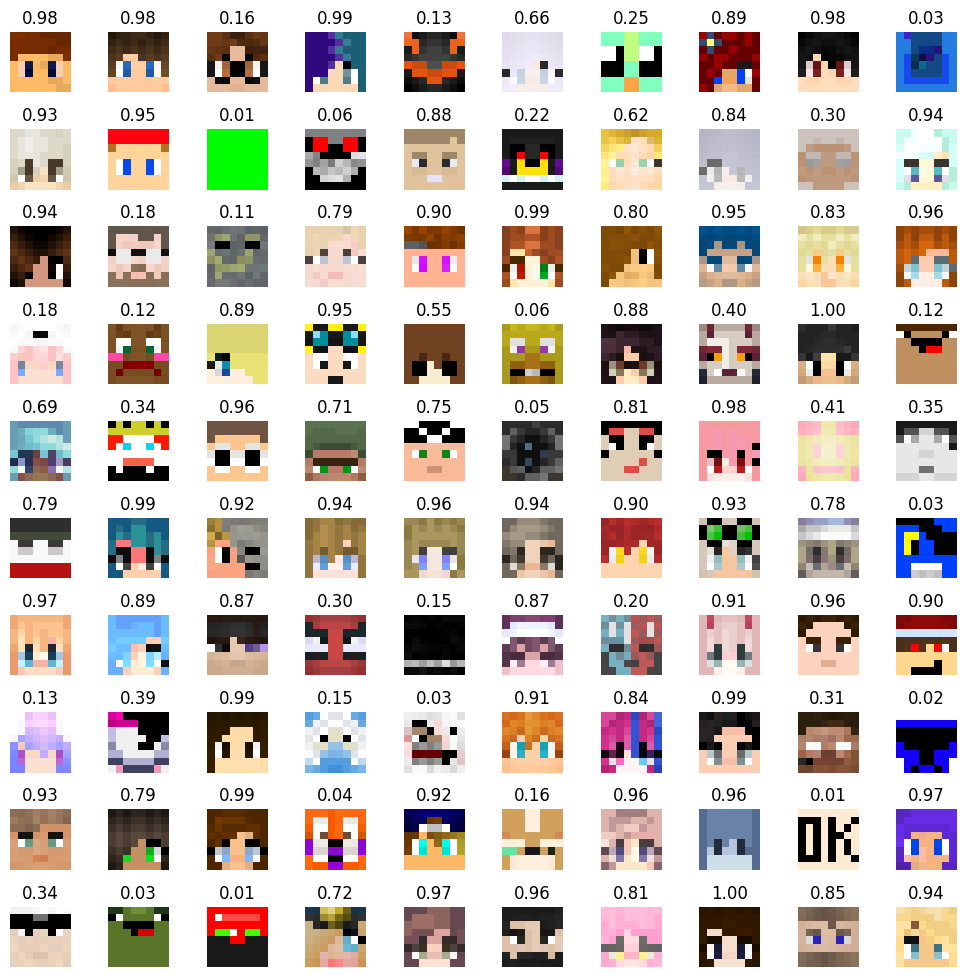

In [107]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

start_indx = 2100
for i in range(start_indx, start_indx + 100):
    lab_img = imread(all_faces[i])

    spot = i - start_indx
    axs[spot // 10, spot % 10].imshow(lab_img)
    axs[spot // 10, spot % 10].axis("off")

    title = f"{preds[i]:.02f}"

    axs[spot // 10, spot % 10].set_title(title)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

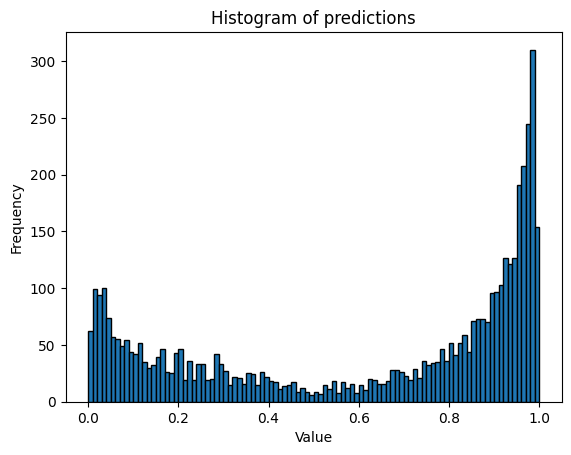

In [109]:
plt.hist(preds, bins=100, range=(0, 1), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of predictions')
plt.show()

In [110]:
preds.max(), preds.min()

(0.9981511235237122, 0.0026889685541391373)

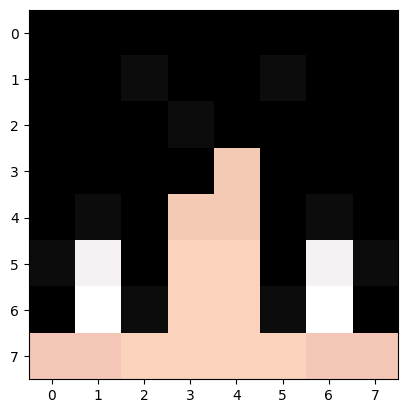

In [112]:
idx = np.where(preds == 0.9981511235237122)[0][0]
lab_img = imread(all_faces[idx])
plt.imshow(lab_img)

In [93]:
_ = np.where(preds < 0.1)[0]
_ = np.array(all_faces)[_]

np.save('./predicted_invalid_faces.npy', _)

## Saving

In [49]:
_ = np.array(all_faces)[np.where(preds > 0.95)[0]]
np.save('predicted_valid_faces.npy', _)

Save valid files

In [12]:
valid_face_indexes = np.array(np.where(preds > 0.7)).squeeze()

In [10]:
if not os.path.isdir(VALID_FACE_DIR):
    os.mkdir(VALID_FACE_DIR)

for valid_index in valid_face_indexes:
    file_name = all_faces[valid_index].split("/")[-1]
    new_path = join(VALID_FACE_DIR, file_name)
    shutil.copy(all_faces[valid_index], new_path)